# K-Nearest Neighbors

The purpose of this notebook is to compare the use of grid search, random search, and Bayesian hyperparameter optimization to find optimal hyperparameter settings for a K-Nearest Neighbors model.

The hyperparameters being evaluated are:

* K = number of neighbors (n_neighbors)
* L1 (p = 1) or L2 distance (p = 2)
* (weights = 'uniform' or 'distance') = whether to weight points uniformly, or give more weight to those that are closer more than those far away

# Imports

In [1]:
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import skopt
from skopt import BayesSearchCV
from skopt.utils import point_asdict
from skopt.space.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, TimerCallback

from data_utils import get_CIFAR10_data  # use code adapted from CS 682 to get the CIFAR10 data

# Load data

In [2]:
# Load the (preprocessed) CIFAR10 data

# Note the data from get_CIFAR10_data are in shape (N, C, W, H). Then we reshape the data to have one row per image. 
# To visualize a given image (x_train[i], for example), run the following:
#     plt.imshow(x_train[i].reshape(3, 32, 32).transpose(1, 2, 0).astype('uint8'))

data = get_CIFAR10_data(subtract_mean=True)
for k, v in data.items():
    tmp = v.shape
    if len(tmp) > 1:
        data[k] = v.reshape((v.shape[0], -1))
    print('{}: {} --> {}'.format(k, tmp, data[k].shape))

x_train = data['X_train']
y_train = data['y_train']
x_test = data['X_test']
y_test = data['y_test']

X_train: (50000, 3, 32, 32) --> (50000, 3072)
y_train: (50000,) --> (50000,)
X_test: (1000, 3, 32, 32) --> (1000, 3072)
y_test: (1000,) --> (1000,)


In [3]:
# define the splitting strategy, which will be used for all approaches
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=682)

In [4]:
# Subset the data to 4 classes for runtime purposes, and because the simpler models
# don't tend to get good accuracy when there are many classes
np.random.seed(175)
classes = np.random.choice(range(10), size=4, replace=False)
print(classes)

x_train_4class = x_train[np.isin(y_train, classes)]
y_train_4class = y_train[np.isin(y_train, classes)]

# check on size of dataset
print([x_train_4class.shape, y_train_4class.shape])

# check on class balance
np.unique(y_train_4class, return_counts=True)

[7 2 8 0]
[(20000, 3072), (20000,)]


(array([0, 2, 7, 8]), array([5000, 5000, 5000, 5000]))

# Grid Search

In [5]:
gs_hyperparameters = {
    'n_neighbors': range(2, 40, 6),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [6]:
clf = KNeighborsClassifier(n_jobs=4)

gs = GridSearchCV(clf,
                  param_grid=gs_hyperparameters,
                  scoring='accuracy',
                  cv=cv_folds,
                  refit=False,
                  verbose=5, 
                  n_jobs=1)

print('Beginning grid search at {}...'.format(datetime.now().strftime('%H:%M:%S')))
gs.fit(x_train_4class, y_train_4class)

gs_results = []
for i in range(len(gs.cv_results_['params'])):
    result = {'params' : gs.cv_results_['params'][i], 
              'mean_metric' : gs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': gs.cv_results_['mean_fit_time'][i],
              'mean_score_time': gs.cv_results_['mean_score_time'][i]}
    gs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']), flush=True)


print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))

with open('knn_gs_results_{}.pkl'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), 'wb') as f:
    pickle.dump({'gs_results': gs_results, 'gs': gs}, f)
    
print('Finished grid search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

Beginning grid search at 14:36:42...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] n_neighbors=2, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.572, total= 1.9min
[CV] n_neighbors=2, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.589, total= 1.9min
[CV] n_neighbors=2, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.564, total= 1.9min
[CV] n_neighbors=2, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.568, total= 1.9min
[CV] n_neighbors=2, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.7min remaining:    0.0s


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.560, total= 1.9min
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=0.618, total= 1.9min
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=0.631, total= 1.9min
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=0.612, total= 1.9min
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=0.613, total= 1.9min
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=0.603, total= 1.9min
[CV] n_neighbors=2, p=2, weights=uniform .............................
[CV] . n_neighbors=2, p=2, weights=uniform, score=0.559, total= 1.9min
[CV] n_neighbors=2, p=2, weights=uniform .............................
[CV] .

[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 270.4min finished


## Grid Search Plots

In [7]:
print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}, 'mean_metric': 0.63345, 'mean_fit_time': 7.596310472488403, 'mean_score_time': 107.76474776268006}


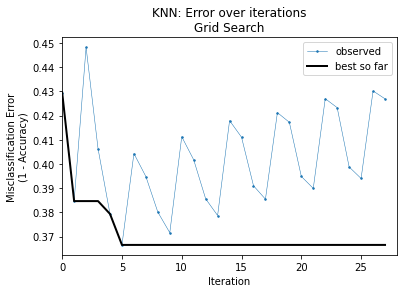

In [8]:
# convergence plot
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("KNN: Error over iterations\nGrid Search")
plt.xlim((0,28))
plt.legend()

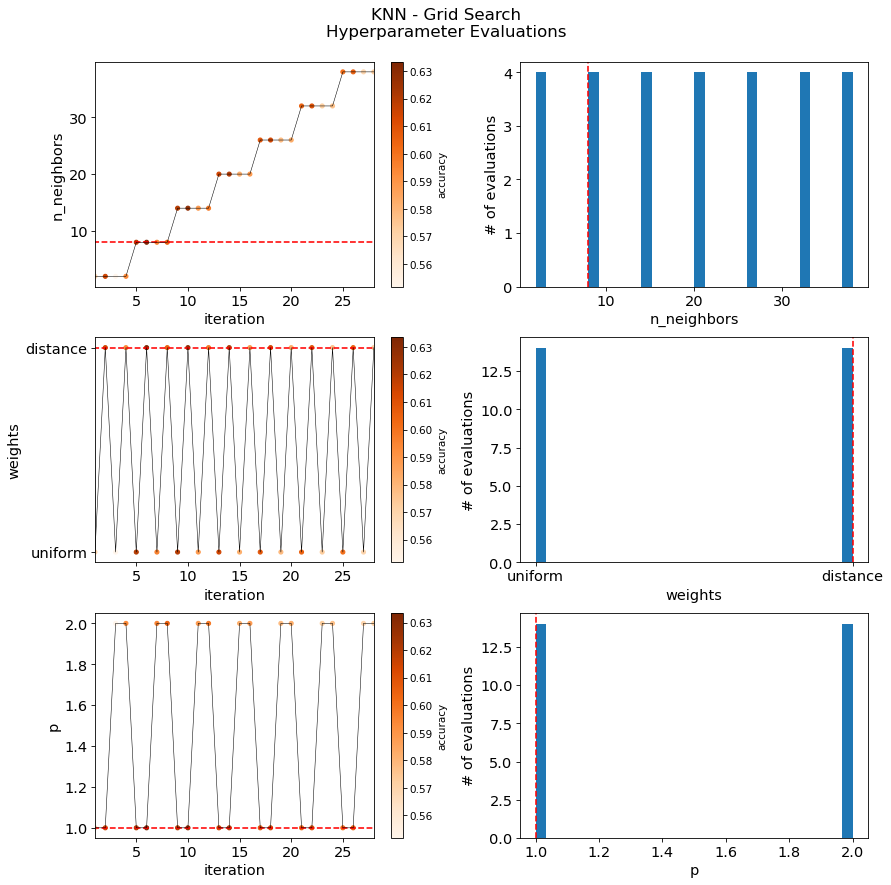

In [9]:
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

params = gs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in gs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = gs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("KNN - Grid Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])

# Random Search

In [10]:
rs_hyperparameters = {
    'n_neighbors': range(2, 40),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

N_EVALS = 28  # same number as were evaluated in grid search above

In [11]:
clf = KNeighborsClassifier(n_jobs=4)

rs = RandomizedSearchCV(clf,
                        param_distributions=rs_hyperparameters,
                        n_iter=N_EVALS,
                        scoring='accuracy',
                        cv=cv_folds,
                        refit=False,
                        verbose=5, 
                        n_jobs=1,
                        random_state=682)


print('\n--------------------------------------\nBeginning random search at {}...'.format(datetime.now().strftime('%H:%M:%S')))
rs.fit(x_train_4class, y_train_4class)

rs_results = []
for i in range(len(rs.cv_results_['params'])):
    result = {'params' : rs.cv_results_['params'][i], 
              'mean_metric' : rs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': rs.cv_results_['mean_fit_time'][i],
              'mean_score_time': rs.cv_results_['mean_score_time'][i]}
    rs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']), flush=True)


print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))

with open('knn_rs_results_{}.pkl'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), 'wb') as f:
    pickle.dump({'rs_results': rs_results, 'rs': rs}, f)
    
print('Finished with random search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning random search at 19:07:08...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] weights=uniform, p=1, n_neighbors=28 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=uniform, p=1, n_neighbors=28, score=0.614, total= 1.9min
[CV] weights=uniform, p=1, n_neighbors=28 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=28, score=0.617, total= 1.9min
[CV] weights=uniform, p=1, n_neighbors=28 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=28, score=0.603, total= 1.9min
[CV] weights=uniform, p=1, n_neighbors=28 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=28, score=0.602, total= 1.9min
[CV] weights=uniform, p=1, n_neighbors=28 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.7min remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=28, score=0.599, total= 1.9min
[CV] weights=distance, p=1, n_neighbors=29 ...........................
[CV]  weights=distance, p=1, n_neighbors=29, score=0.618, total= 1.9min
[CV] weights=distance, p=1, n_neighbors=29 ...........................
[CV]  weights=distance, p=1, n_neighbors=29, score=0.622, total= 1.9min
[CV] weights=distance, p=1, n_neighbors=29 ...........................
[CV]  weights=distance, p=1, n_neighbors=29, score=0.607, total= 1.9min
[CV] weights=distance, p=1, n_neighbors=29 ...........................
[CV]  weights=distance, p=1, n_neighbors=29, score=0.608, total= 1.9min
[CV] weights=distance, p=1, n_neighbors=29 ...........................
[CV]  weights=distance, p=1, n_neighbors=29, score=0.606, total= 1.9min
[CV] weights=distance, p=2, n_neighbors=32 ...........................
[CV]  weights=distance, p=2, n_neighbors=32, score=0.581, total= 1.9min
[CV] weights=distance, p=2, n_neighbors=32 ...........................


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 269.2min finished


## Random Search Plots

In [12]:
print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'weights': 'distance', 'p': 1, 'n_neighbors': 5}, 'mean_metric': 0.6363, 'mean_fit_time': 7.469804334640503, 'mean_score_time': 105.36066751480102}


In [13]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

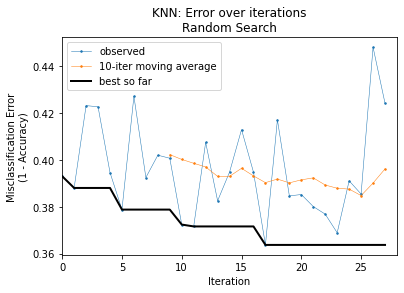

In [14]:
# convergence plot, RS
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("KNN: Error over iterations\nRandom Search")
plt.xlim((0,28))
plt.legend()

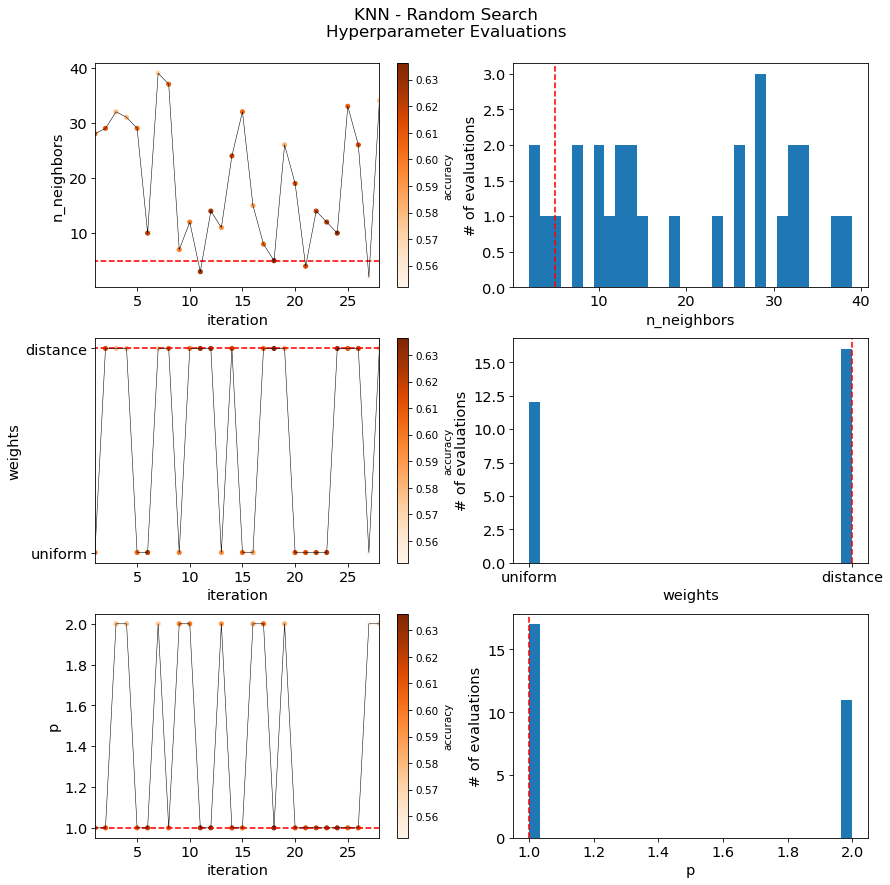

In [15]:
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = rs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in rs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = rs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("KNN - Random Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])

# Bayesian Search

In [16]:
bs_hyperparameters = {
    'n_neighbors': Integer(2, 40),
    'weights': Categorical(['uniform', 'distance']),
    'p': Integer(1, 2)
}

N_EVALS = 28  # same number as were evaluated in grid search above

In [17]:
def cb_print(result):
    ## to be called by BayesSearchCV fit() to print out each iteration
    
    # save progress at each iteration in case of error
    skopt.dump(result, 'tmp_bayes_result_{}.pkl'.format(datetime.now().strftime("%Y%m%d")))
    
    def stringify_params(params):
        # to take the list of hyperparameter values and get a dictionary back out
        params = point_asdict(bs_hyperparameters, params)
        return ', '.join([f'{k}={v}' if type(v) != str else f'{k}="{v}"' \
                          for k, v in params.items()])
    
    score = -(result.func_vals[-1])
    params = stringify_params(result.x_iters[-1])

    # argmin because the values are negative during search
    best_score_pos = np.argmin(result.func_vals)
    
    num_tried = len(result.func_vals)
    N = result.specs['args']['n_initial_points']

    the_time = datetime.now().strftime("%H:%M:%S")
    if best_score_pos == (num_tried - 1):
        print(f'***New best! [{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})\n', flush=True)
    else:
        print(f'[{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})', flush=True)
        best_params = stringify_params(result.x_iters[best_score_pos])
        print('    Best accuracy = {} ({})\n'.format(-result.func_vals[best_score_pos], best_params), flush=True)

In [20]:
clf = KNeighborsClassifier(n_jobs=4)

print('\n--------------------------------------\nBeginning Bayes search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

bayes = BayesSearchCV(
    estimator = clf,
    search_spaces = bs_hyperparameters,
    scoring = 'accuracy',
    cv = cv_folds,
    n_jobs = 1,
    n_iter = N_EVALS,
    refit = False,
    random_state = 682
)

early_stopper = DeltaYStopper(0.001)  # stop when the top 5 results are all within 0.1% accuracy of the best
timercb = TimerCallback()
bayes_result = bayes.fit(x_train_4class, y_train_4class, callback=[timercb, cb_print, early_stopper])

# export both the results AND the fitted object
the_time = datetime.now().strftime("%Y%m%d_%H%M%S")
skopt.dump(bayes_result, 'knn_bayes_result_{}.pkl'.format(the_time))

with open(f'knn_bayes_timercb_{the_time}.pkl', 'wb') as f:
    pickle.dump(timercb, f)

print('Finished with Bayes search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

scores = bayes_result.cv_results_['mean_test_score']
param_keys = [x for x in bayes_result.cv_results_.keys() if 'param_' in x]
tmp = [bayes_result.cv_results_[x] for x in param_keys] + [scores]
tmp = list(map(list, zip(*tmp)))
tmp = [dict(zip(param_keys + ['mean_test_score'], x)) for x in tmp]
pd.DataFrame(tmp)


--------------------------------------
Beginning Bayes search at 09:00:48...
***New best! [09:14:33] (Iter 1) Accuracy = 0.6012 (n_neighbors=11, p=2, weights="distance")

***New best! [09:25:15] (Iter 2) Accuracy = 0.61195 (n_neighbors=29, p=1, weights="distance")

[09:34:53] (Iter 3) Accuracy = 0.57785 (n_neighbors=30, p=2, weights="distance")
    Best accuracy = 0.61195 (n_neighbors=29, p=1, weights="distance")

[09:44:25] (Iter 4) Accuracy = 0.6075 (n_neighbors=37, p=1, weights="distance")
    Best accuracy = 0.61195 (n_neighbors=29, p=1, weights="distance")

***New best! [09:54:07] (Iter 5) Accuracy = 0.6221 (n_neighbors=18, p=1, weights="distance")

[10:03:56] (Iter 6) Accuracy = 0.57985 (n_neighbors=22, p=2, weights="uniform")
    Best accuracy = 0.6221 (n_neighbors=18, p=1, weights="distance")

[10:13:41] (Iter 7) Accuracy = 0.603 (n_neighbors=10, p=2, weights="distance")
    Best accuracy = 0.6221 (n_neighbors=18, p=1, weights="distance")

***New best! [10:23:24] (Iter 8) Accu

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[11:31:35] (Iter 15) Accuracy = 0.62495 (n_neighbors=7, p=1, weights="uniform")
    Best accuracy = 0.62495 (n_neighbors=7, p=1, weights="uniform")

[11:41:19] (Iter 16) Accuracy = 0.5705 (n_neighbors=2, p=1, weights="uniform")
    Best accuracy = 0.62495 (n_neighbors=7, p=1, weights="uniform")

[11:51:00] (Iter 17) Accuracy = 0.6212 (n_neighbors=10, p=1, weights="uniform")
    Best accuracy = 0.62495 (n_neighbors=7, p=1, weights="uniform")

[12:00:44] (Iter 18) Accuracy = 0.6192 (n_neighbors=22, p=1, weights="distance")
    Best accuracy = 0.62495 (n_neighbors=7, p=1, weights="uniform")

***New best! [12:10:26] (Iter 19) Accuracy = 0.62875 (n_neighbors=13, p=1, weights="distance")

***New best! [12:20:06] (Iter 20) Accuracy = 0.63345 (n_neighbors=8, p=1, weights="distance")

[12:29:46] (Iter 21) Accuracy = 0.61185 (n_neighbors=24, p=1, weights="uniform")
    Best accuracy = 0.63345 (n_neighbors=8, p=1, weights="distance")

[12:39:19] (Iter 22) Accuracy = 0.5937 (n_neighbors=2, p=2, we

,param_n_neighbors,param_p,param_weights,mean_test_score
0,11,2,distance,0.60120
1,29,1,distance,0.61195
2,30,2,distance,0.57785
3,37,1,distance,0.60750
4,18,1,distance,0.62210
5,22,2,uniform,0.57985
6,10,2,distance,0.60300
7,7,1,uniform,0.62495
8,28,2,uniform,0.57495
9,30,2,distance,0.57785


## Bayesian Plots

In [21]:
bayes_result.best_params_

OrderedDict([('n_neighbors', 6), ('p', 1), ('weights', 'distance')])

In [22]:
bayes_result.best_score_

0.63735

In [23]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

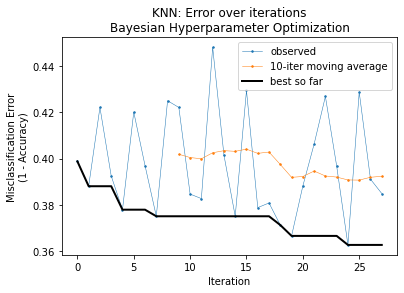

In [24]:
# convergence plot
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("KNN: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend()

Text(0.5, 1.0, 'KNN Runtime\nModel vs. Bayesian Search Contribution')

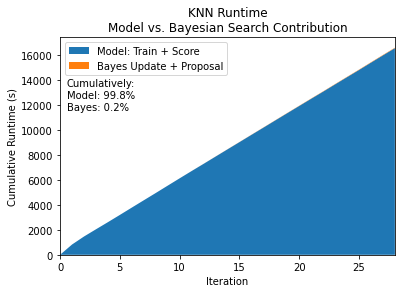

In [25]:
#### runtime plot: model vs. bayesian

plt.close('all')
model_times = np.array(bayes_result.cv_results_['mean_fit_time'])*5 + \
              np.array(bayes_result.cv_results_['mean_score_time'])*5 
total_times = np.array(timercb.iter_time)
bayes_times = total_times - model_times

cumul_totaltime = total_times.cumsum()
cumul_modeltime = model_times.cumsum()
cumul_bayestime = bayes_times.cumsum()

bayes_frac = cumul_bayestime[-1]/cumul_totaltime[-1]
model_frac = cumul_modeltime[-1]/cumul_totaltime[-1]

plt.stackplot(range(0, len(model_times) + 1), [0, *cumul_modeltime], [0, *cumul_bayestime], 
              labels=['Model: Train + Score', 'Bayes Update + Proposal'])
plt.legend(loc='upper left')
plt.xlim((0, len(model_times)))
plt.xlabel('Iteration')
plt.ylabel('Cumulative Runtime (s)')
plt.annotate('Cumulatively:\nModel: {}%\nBayes: {}%'.format(round(model_frac * 100, 1), round(bayes_frac * 100, 1)), 
             (0.02*len(model_times), 0.7*cumul_totaltime[-1]))
plt.title('KNN Runtime\nModel vs. Bayesian Search Contribution')

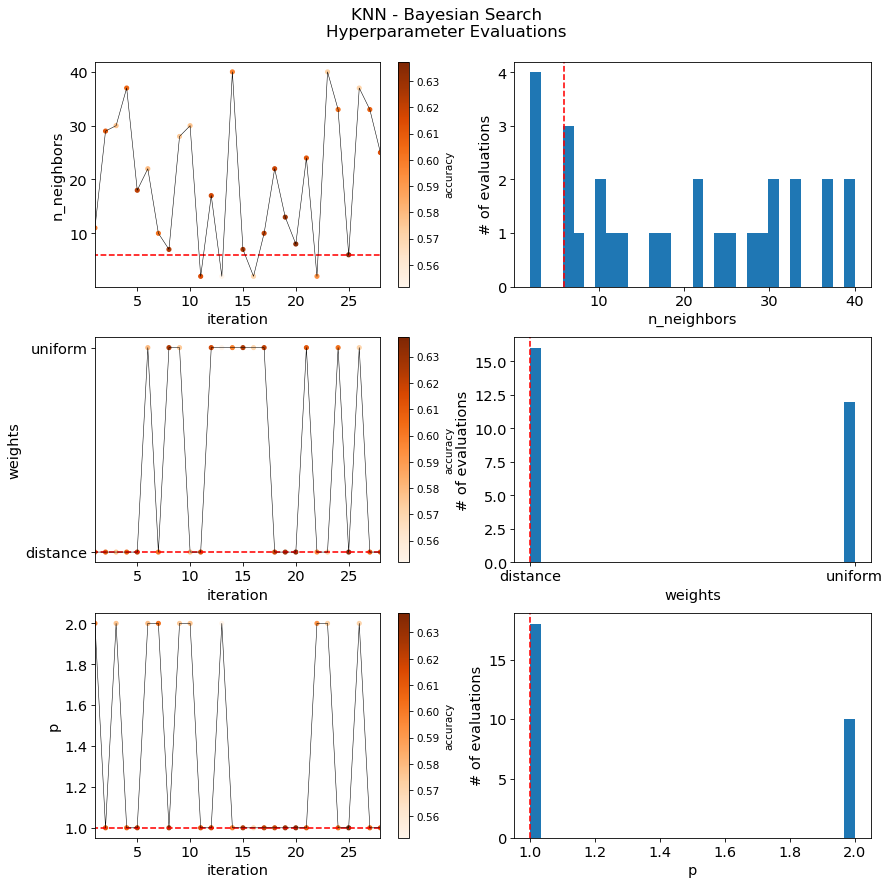

In [26]:
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = bayes_result.search_spaces.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = bayes_result.cv_results_[f'param_{param}']
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = bayes_result.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("KNN - Bayesian Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])


# Combined Plots

In [27]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

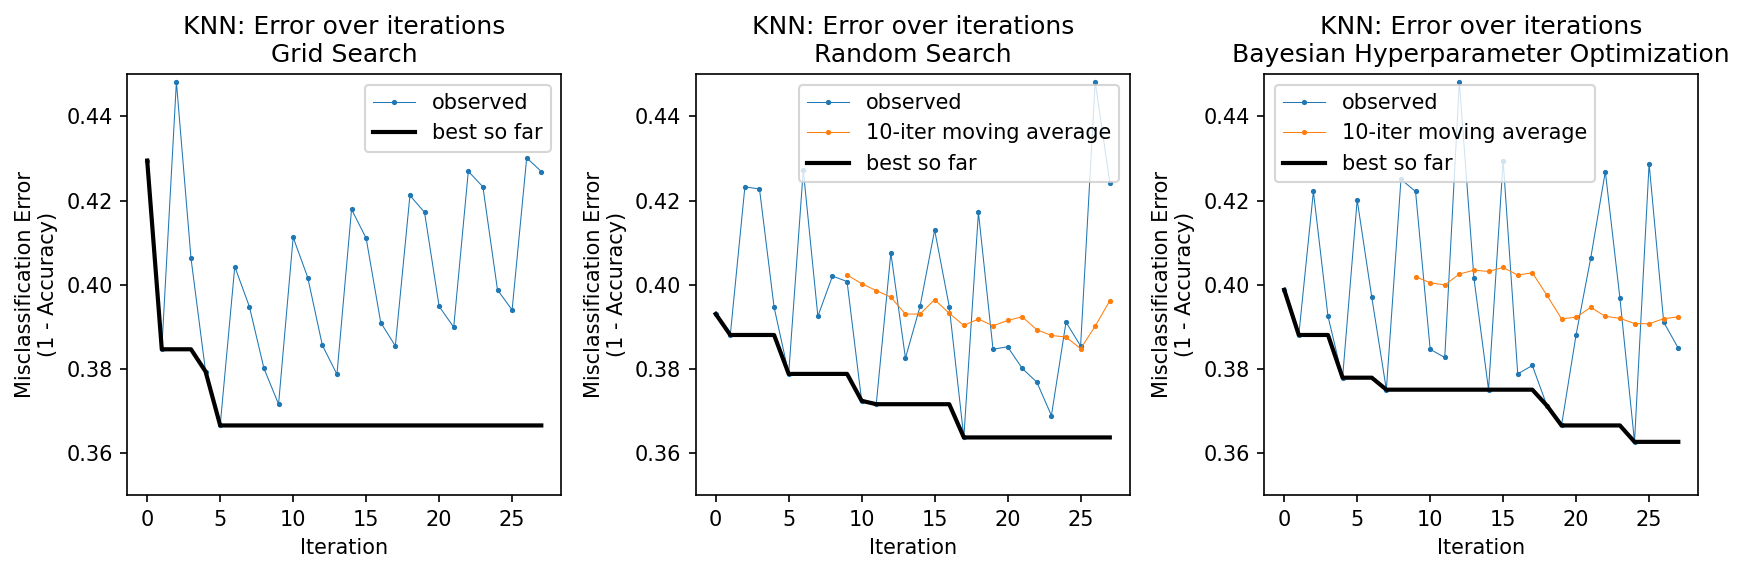

In [28]:
plt.close('all')
plt.figure(figsize=(12, 4), dpi=150)


####### convergence plot, GS
plt.subplot(1, 3, 1)

accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("KNN: Error over iterations\nGrid Search")
plt.legend()
plt.ylim((.35, .45))


####### convergence plot, RS
plt.subplot(1, 3, 2)

accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("KNN: Error over iterations\nRandom Search")
plt.legend()
plt.ylim((.35, .45))


####### convergence plot, Bayesian
plt.subplot(1, 3, 3)

accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("KNN: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend()
plt.ylim((.35, .45))


plt.tight_layout(rect=[0, 0.0, .96, 0.98])

# Get CSVs + best model summaries

In [ ]:
############################ 
# Only uncomment the below if you are making these summaries in a different
# session from when you ran the above.
############################ 

#bayes_result = skopt.load('knn_bayes_result_20201107-020639.pkl')

#with open('knn_gs_results_201107_072620.pkl', 'rb') as f:
#    gs_results = pickle.load(f)
#gs = gs_results['gs']
#gs_results = gs_results['gs_results']

#with open('knn_rs_results_201107_124711.pkl', 'rb') as f:
#    rs_results = pickle.load(f)
#rs = rs_results['rs']
#rs_results = rs_results['rs_results']

In [29]:
print('\nGrid search best model:')
best = max(gs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Grid search best model:
    Score = 0.63345
    n_neighbors = 8
    p = 1
    weights = distance


In [30]:
print('\nRandom search best model:')
best = max(rs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Random search best model:
    Score = 0.6363
    n_neighbors = 5
    p = 1
    weights = distance


In [31]:
print('\nBayes search best model:')
print('    Score = {}'.format(bayes_result.best_score_))
for param in sorted(bayes_result.best_params_.keys()):
    print('    {} = {}'.format(param, bayes_result.best_params_[param]))


Bayes search best model:
    Score = 0.63735
    n_neighbors = 6
    p = 1
    weights = distance


In [32]:
df_results = pd.DataFrame()
for res in gs_results:
    row = {'search_type': 'grid', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [33]:
for res in rs_results:
    row = {'search_type': 'random', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [34]:
for i, cv_score in enumerate(bayes_result.cv_results_['mean_test_score']):
    row = {'search_type': 'bayes', 'accuracy': cv_score}
    for param in bayes_result.search_spaces.keys():
        row[param] = bayes_result.cv_results_['param_' + param][i]
    df_results = df_results.append(row, ignore_index=True)

In [35]:
df_results.to_csv('knn_results_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)